In [23]:
%matplotlib inline


# 04 eXtreme Gradient Boosting regression

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold
import pandas as pd

pd.set_option('display.max_columns', 30)
pd.set_option('display.precision', 3)


## Time-independent regression with `df_X_pca` and `df_y`




In [25]:
df_X_pca = pd.read_pickle('df_X_pca.pkl')
X_cols = df_X_pca.columns

df_y = pd.read_pickle('df_y.pkl')
y_cols = df_y.columns

X = df_X_pca.to_numpy()
y = df_y.to_numpy()

print('X.shape = ', X.shape, ', y.shape = ', y.shape)

X.shape =  (1229, 50) , y.shape =  (1229, 6)


### Train-val-test split

Even when attempting time-independent regression, we cannot shuffle the data set before making train and test plit. If the model should be able to predict output variables ahead in time, it has to work well on a chronologically split data set.

For XGBoost we use a sperarate (random) part of the training set as evaluation set.


In [26]:
split_test = int(len(X)*0.8)
X_train, X_test = X[:split_test,:], X[split_test+1:,:]
y_train, y_test = y[:split_test,:], y[split_test+1:,:]

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print('X_train:', X_train.shape, 'X_val:', X_val.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_val:', y_val.shape, 'y_test:', y_test.shape)

Note = 'PCA50. Random train/val but end as test.'

X_train: (737, 50) X_val: (246, 50) X_test: (245, 50)
y_train: (737, 6) y_val: (246, 6) y_test: (245, 6)


In [27]:
params = {
    "objective": "reg:squarederror",
    "random_state": 42,
    "subsample": 0.5, # subsample ratio of columns when constructing each tree.
    'colsample_bytree': 0.5,
    #'alpha': 0.5757147587224918,
    #'lambda': 0.6751025760853637,
    #'gamma': 0.004714915573102214,
    #'learning_rate': 0.18832358744106376,
    #'max_depth': 5,
    #'n_estimators': 269
    "alpha": 0.5, # L1 regularization term on weights. Increasing this value will make model more conservative.
    "lambda": 1, # L2 regularization term on weights. Increasing this value will make model more conservative.
    "gamma": 0.01, # Minimum loss reduction required to make a further partition on a leaf node of the tree. Higher -> more conservative. [0,inf]
    "learning_rate": 0.03, # default 0.3 
    "max_depth": 4, # default 3
    "n_estimators": 400, # default 100
    #"verbose_eval": True# Chose wether to print output during training (1) or no printing (0)
}

### Fit regression model


In [28]:
# Prepare dataframe of rmse results and parameter values, or load existing dataframe from file if `fit_file`exists

fit_file = '04_fitting_results.pkl' # NB: Update name according to notebook number

if os.path.exists(fit_file):
    fit_results = pd.read_pickle(fit_file)
else:
    res_cols = ['Note']
    for col in df_y.columns:
        res_cols.append(col+' S_e')
    res_cols.append('S_e mean')
    for key in params.keys():
        res_cols.append(key)
    res_cols.append('Training time')
        
    fit_results = pd.DataFrame(columns=res_cols)


start_time = datetime.now()


# ----------------- Calculate root mean squared error of predictions and -------------------------
# ----------------- store results in dataframe together with parameter values used -------------------------
res_labels = ['Note']
res_values = [Note]

regs = []
y_test_estimated = []
y_test_error = []
S_e_values = []

for i in range(y_train.shape[1]):
    reg = XGBRegressor(**params) 
    reg.set_params(early_stopping_rounds=20)
    history = reg.fit(X_train, y_train[:,i], eval_set=[(X_val, y_val[:,i])]) # Fit model for label i
    regs.append(reg)

    y_test_estimated.append(reg.predict(X_test)) # Predict label values on test set
    y_test_error.append(y_test[:,i] - y_test_estimated[i])
    S_e = np.std(y_test_error[i])/np.std(y_test[:,i])
    res_values.append(S_e)
    label = y_cols[i]
    res_labels.append(label+' S_e')
    
    S_e_values.append(S_e)

res_labels.append('S_e mean')
res_values.append(np.mean(S_e_values))

for key in params.keys():
    res_values.append(params[key])
    res_labels.append(key)

training_time = (datetime.now() - start_time).total_seconds()
res_values.append(training_time)
res_labels.append('Training time')

df_tmp = pd.DataFrame([res_values], columns=res_labels, index=[datetime.now().date()])
fit_results = fit_results.append(df_tmp)
#fit_results = fit_results.sort_values('R2', ascending=False)
fit_results.to_pickle(fit_file)
fit_results

[0]	validation_0-rmse:1.12050
[1]	validation_0-rmse:1.11600
[2]	validation_0-rmse:1.11070
[3]	validation_0-rmse:1.10528
[4]	validation_0-rmse:1.09974
[5]	validation_0-rmse:1.09546
[6]	validation_0-rmse:1.09052
[7]	validation_0-rmse:1.08683
[8]	validation_0-rmse:1.08314
[9]	validation_0-rmse:1.07723
[10]	validation_0-rmse:1.07305
[11]	validation_0-rmse:1.07024
[12]	validation_0-rmse:1.06693
[13]	validation_0-rmse:1.06448
[14]	validation_0-rmse:1.06223
[15]	validation_0-rmse:1.05865
[16]	validation_0-rmse:1.05762
[17]	validation_0-rmse:1.05487
[18]	validation_0-rmse:1.05135
[19]	validation_0-rmse:1.04833
[20]	validation_0-rmse:1.04489
[21]	validation_0-rmse:1.04377
[22]	validation_0-rmse:1.04299
[23]	validation_0-rmse:1.04177
[24]	validation_0-rmse:1.03941
[25]	validation_0-rmse:1.03787
[26]	validation_0-rmse:1.03571
[27]	validation_0-rmse:1.03419
[28]	validation_0-rmse:1.03427
[29]	validation_0-rmse:1.03221
[30]	validation_0-rmse:1.02964
[31]	validation_0-rmse:1.02817
[32]	validation_0-

C:\Users\christiano\AppData\Local\Temp\ipykernel_3008\2365160989.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fit_results = fit_results.append(df_tmp)


,Note,y1 S_e,y2 S_e,y3 S_e,y4 S_e,y5 S_e,y6 S_e,S_e mean,objective,random_state,subsample,colsample_bytree,alpha,lambda,gamma,learning_rate,max_depth,n_estimators,Training time
2023-02-16,PCA50. Random train/val but end as test.,1.092,0.743,1.049,0.753,0.846,0.99,0.912,reg:squarederror,42,0.5,0.5,0.5,1,0.01,0.03,4,400,26.511


## Time dependent regression with `df_X_lagged` and `df_y_lagged`

The reason for not using `df_y` here is that `df_X_lagged` contains fewer rows and we need a coherent set of labels



In [6]:
df_X_lagged = pd.read_pickle('df_X_lagged.pkl')
X_cols = df_X_lagged.columns

df_y_lagged = pd.read_pickle('df_y_lagged.pkl')
y_cols = df_y_lagged.columns

X = df_X_lagged.to_numpy()
y = df_y_lagged.to_numpy()

print('X.shape = ', X.shape, ', y.shape = ', y.shape)

X.shape =  (1224, 330) , y.shape =  (1224, 6)


### Train-val-test split


In [7]:
split_test = int(len(X)*0.8)
X_train, X_test = X[:split_test,:], X[split_test+1:,:]
y_train, y_test = y[:split_test,:], y[split_test+1:,:]

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print('X_train:', X_train.shape, 'X_val:', X_val.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_val:', y_val.shape, 'y_test:', y_test.shape)

Note = 'df_X_lagged. Random train/val but end as test.'

X_train: (734, 330) X_val: (245, 330) X_test: (244, 330)
y_train: (734, 6) y_val: (245, 6) y_test: (244, 6)


In [8]:
params = {
    "objective": "reg:squarederror",
    "random_state": 42,
    "subsample": 0.6, # subsample ratio of columns when constructing each tree.
    'colsample_bytree': 0.6,
    'min_child_weight': 1,
    #'alpha': 0.5757147587224918,
    #'lambda': 0.6751025760853637,
    #'gamma': 0.004714915573102214,
    #'learning_rate': 0.18832358744106376,
    #'max_depth': 5,
    #'n_estimators': 269
    "alpha": 0.5, # L1 regularization term on weights. Increasing this value will make model more conservative.
    "lambda": 1, # L2 regularization term on weights. Increasing this value will make model more conservative.
    "gamma": 0.01, # Minimum loss reduction required to make a further partition on a leaf node of the tree. Higher -> more conservative. [0,inf]
    "learning_rate": 0.03, # default 0.3 
    "max_depth": 3, # default 3
    "n_estimators": 400, # default 100
    #"verbose_eval": True# Chose wether to print output during training (1) or no printing (0)
}

### Fit regression model


In [9]:
# Prepare dataframe of rmse results and parameter values, or load existing dataframe from file if `fit_file`exists

fit_file = '04_fitting_results.pkl' # NB: Update name according to notebook number

if os.path.exists(fit_file):
    fit_results = pd.read_pickle(fit_file)
else:
    res_cols = ['Note']
    for col in df_y.columns:
        res_cols.append(col+' S_e')
    res_cols.append('S_e mean')
    for key in params.keys():
        res_cols.append(key)
    res_cols.append('Training time')
        
    fit_results = pd.DataFrame(columns=res_cols)


start_time = datetime.now()


# ----------------- Calculate root mean squared error of predictions and -------------------------
# ----------------- store results in dataframe together with parameter values used -------------------------
res_labels = ['Note']
res_values = [Note]

regs = []
y_test_estimated = []
y_test_error = []
S_e_values = []

for i in range(y_train.shape[1]):
    reg = XGBRegressor(**params) 
    reg.set_params(early_stopping_rounds=20)
    history = reg.fit(X_train, y_train[:,i], eval_set=[(X_val, y_val[:,i])]) # Fit model for label i
    regs.append(reg)

    y_test_estimated.append(reg.predict(X_test)) # Predict label values on test set
    y_test_error.append(y_test[:,i] - y_test_estimated[i])
    S_e = np.std(y_test_error[i])/np.std(y_test[:,i])
    res_values.append(S_e)
    label = y_cols[i]
    res_labels.append(label+' S_e')
    
    S_e_values.append(S_e)

res_labels.append('S_e mean')
res_values.append(np.mean(S_e_values))

for key in params.keys():
    res_values.append(params[key])
    res_labels.append(key)

training_time = (datetime.now() - start_time).total_seconds()
res_values.append(training_time)
res_labels.append('Training time')

df_tmp = pd.DataFrame([res_values], columns=res_labels, index=[datetime.now().date()])
fit_results = fit_results.append(df_tmp)
#fit_results = fit_results.sort_values('R2', ascending=False)
fit_results.to_pickle(fit_file)
fit_results

[0]	validation_0-rmse:0.99222
[1]	validation_0-rmse:0.98250
[2]	validation_0-rmse:0.97572
[3]	validation_0-rmse:0.96655
[4]	validation_0-rmse:0.95826
[5]	validation_0-rmse:0.94891
[6]	validation_0-rmse:0.94108
[7]	validation_0-rmse:0.93708
[8]	validation_0-rmse:0.93242
[9]	validation_0-rmse:0.92653
[10]	validation_0-rmse:0.91854
[11]	validation_0-rmse:0.91013
[12]	validation_0-rmse:0.90307
[13]	validation_0-rmse:0.89603
[14]	validation_0-rmse:0.88996
[15]	validation_0-rmse:0.88480
[16]	validation_0-rmse:0.87940
[17]	validation_0-rmse:0.87595
[18]	validation_0-rmse:0.87215
[19]	validation_0-rmse:0.86691
[20]	validation_0-rmse:0.86369
[21]	validation_0-rmse:0.85928
[22]	validation_0-rmse:0.85583
[23]	validation_0-rmse:0.85239
[24]	validation_0-rmse:0.84757
[25]	validation_0-rmse:0.84410
[26]	validation_0-rmse:0.84113
[27]	validation_0-rmse:0.83776
[28]	validation_0-rmse:0.83546
[29]	validation_0-rmse:0.83294
[30]	validation_0-rmse:0.82993
[31]	validation_0-rmse:0.82662
[32]	validation_0-

C:\Users\christiano\AppData\Local\Temp\ipykernel_20812\3553102375.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fit_results = fit_results.append(df_tmp)


,Note,y1 S_e,y2 S_e,y3 S_e,y4 S_e,y5 S_e,y6 S_e,S_e mean,objective,random_state,subsample,colsample_bytree,alpha,lambda,gamma,learning_rate,max_depth,n_estimators,Training time,min_child_weight
2023-02-16,PCA50. Random train/val but end as test.,1.092,0.743,1.049,0.753,0.846,0.990,0.912,reg:squarederror,42,0.5,0.5,0.5,1,0.01,0.03,4,400,26.511,NaN
2023-02-16,df_X_lagged. Random train/val but end as test.,0.997,0.751,0.935,0.748,0.738,0.848,0.836,reg:squarederror,42,0.5,0.5,0.5,1,0.01,0.03,4,400,20.034,NaN
2023-02-17,df_X_lagged. Random train/val but end as test.,0.970,0.722,0.919,0.773,0.711,0.797,0.815,reg:squarederror,42,0.6,0.6,0.5,1,0.01,0.03,3,400,18.005,1.0


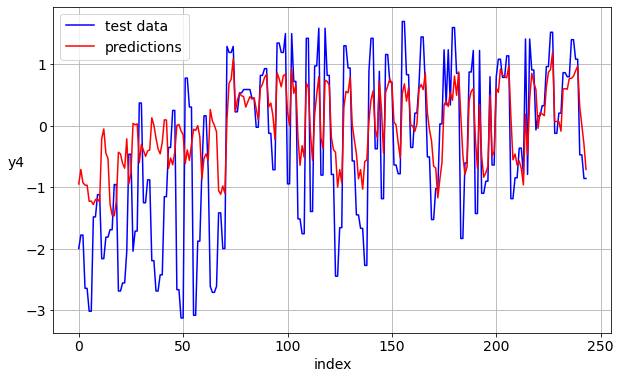

In [76]:
plt.rcParams["font.size"] = 14

label_no = 3
split_test = int(len(X)*0.8)
idx = np.arange(len(y_test[:,label_no]))

plt.plot(idx, y_test[:,label_no], color='b', label='test data')
plt.plot(idx, y_test_estimated[label_no], color='r', label='predictions')
plt.gcf().set_size_inches(10,6)
plt.grid()
plt.legend()

plt.ylabel('y'+str(label_no+1), rotation=0, labelpad=10)
plt.xlabel('index')
plt.savefig('test_estimate_XGB.png')


In [83]:
df_X_lagged = pd.read_pickle('df_X_lagged.pkl')
X_cols = df_X_pca.columns

df_y_lagged = pd.read_pickle('df_y_lagged.pkl')
y_cols = df_y.columns

X = df_X_lagged.to_numpy()
y = df_y_lagged.to_numpy()

split_test = int(len(X)*0.8)
X_train, X_test = X[:split_test,:], X[split_test+1:,:]
y_train, y_test = y[:split_test,3], y[split_test+1:,3]

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print('X_train:', X_train.shape, 'X_val:', X_val.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_val:', y_val.shape, 'y_test:', y_test.shape)

X_train: (734, 330) X_val: (245, 330) X_test: (244, 330)
y_train: (734,) y_val: (245,) y_test: (244,)


Grid Search hyperparameter tuning

In [10]:
from sklearn.model_selection import GridSearchCV

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

params = {
        #'min_child_weight': [1, 5, 10],
        'gamma': [0.005, 0.01, 0.02, 0.05],
        'subsample': [0.4, 0.5, 0.6],
        'colsample_bytree': [0.4, 0.5, 0.6],
        'max_depth': [3, 4, 5],
        }

xgb = XGBRegressor(learning_rate=0.03, n_estimators=400, 'min_child_weight'= 1,
                 objective= "reg:squarederror", random_state=42, silent=True,
                  nthread=1, early_stopping_rounds=20)
folds = 3
param_comb = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='roc_auc', n_jobs=4, cv=kf.split(X_train,y_train), verbose=3)

start_time = timer(None)
grid.fit(X_train, y_train, eval_set=[(X_val, y_val)])
timer(start_time)

results = pd.DataFrame(grid.cv_results_)
results.to_csv('xgb-grid-search-results-01.csv', index=False)

SyntaxError: invalid syntax (3252123349.py, line 20)

NameError: name 'grid' is not defined